# Introduction

This notebook will deploy the Catalog Enrichment System - a GenAI-powered blueprint that transforms basic product images into comprehensive, rich catalog entries.

You will install the necessary prerequisites and spin up the following microservices:

- NVIDIA Nemotron VLM for intelligent product image analysis
- NVIDIA Nemotron LLM for context-aware prompt planning
- FLUX for generating high-quality product variation images
- TRELLIS for 3D asset generation (GLB models)


# Getting Started
>[Prerequisites](#Prerequisites)  
>[Spin Up Blueprint](#Spin-Up-Blueprint)
>[Access the Web Interface](#Access-the-Web-Interface)
>[Shutting Down Blueprint](#Stopping-Services-and-Cleaning-Up)
________________________


## Prerequisites

### Clone repository and install software

1. **Clone** <name> Git repository

In [ ]:
!git clone https://github.com/NVIDIA-AI-Blueprints/Retail-Catalog-Enrichment.git
%cd Retail-Catalog-Enrichment

2. Install **[Docker](https://docs.docker.com/engine/install/ubuntu/)**

<div class="alert alert-block alert-success">
    <b>Tip:</b> Ensure the Docker Compose plugin version is 2.29.1 or higher.  Run docker compose version to confirm. Refer to Install the Compose plugin Docker documentation for more information.

3. Install **[NVIDIA Container Toolkit](https://docs.nvidia.com/datacenter/cloud-native/container-toolkit/latest/install-guide.html#installing-the-nvidia-container-toolkit)** to configure Docker for GPU-accelerated containers. If you are using a system deployed with **Brev you can skip this step** since Brev systems come with NVIDIA Container Toolkit preinstalled. 



### Get a API Keys

#### Let's start by logging into the NVIDIA Container Registry. 
 
The NVIDIA NGC API Key is a mandatory key that is required to use this blueprint. This is needed to log into the NVIDIA container registry, nvcr.io, and to pull secure container images used in this NVIDIA NIM Blueprint.
Refer to [Generating NGC API Keys](https://docs.nvidia.com/ngc/gpu-cloud/ngc-user-guide/index.html#generating-api-key) in the NVIDIA NGC User Guide for more information.

#### Next, let's set the NVIDIA API Catalog key. 

This NVIDIA API Catalog key will be used to access cloud hosted models in API Catalog.

You can use different model API endpoints with the same API key.

1. Navigate to **[NVIDIA API Catalog](https://build.nvidia.com/explore/discover)**.

2. Select a model, such as llama3-8b-instruct.
   

3. Select an **Input** option. The following example is of a model that offers a Docker option. Not all of the models offer this option, but all include a “Get API Key” link

<img src="https://docscontent.nvidia.com/dims4/default/d6307a8/2147483647/strip/true/crop/1920x919+0+0/resize/2880x1378!/format/webp/quality/90/?url=https%3A%2F%2Fk3-prod-nvidia-docs.s3.us-west-2.amazonaws.com%2Fbrightspot%2Fsphinx%2F00000192-bfa6-da2c-a1f2-ffbf41aa0000%2Fnim%2Flarge-language-models%2Flatest%2F_images%2Fbuild_docker_tab.png" />

3. Click **Get API Key**.

<img src="https://docscontent.nvidia.com/dims4/default/c6e2096/2147483647/strip/true/crop/1920x919+0+0/resize/2880x1378!/format/webp/quality/90/?url=https%3A%2F%2Fk3-prod-nvidia-docs.s3.us-west-2.amazonaws.com%2Fbrightspot%2Fsphinx%2F00000192-bfa6-da2c-a1f2-ffbf41aa0000%2Fnim%2Flarge-language-models%2Flatest%2F_images%2Fbuild_get_api_key.png" />

4. Select **"Generate Key"**

<img src="https://docscontent.nvidia.com/dims4/default/e7c4057/2147483647/strip/true/crop/1920x919+0+0/resize/2880x1378!/format/webp/quality/90/?url=https%3A%2F%2Fk3-prod-nvidia-docs.s3.us-west-2.amazonaws.com%2Fbrightspot%2Fsphinx%2F00000192-bfa6-da2c-a1f2-ffbf41aa0000%2Fnim%2Flarge-language-models%2Flatest%2F_images%2Fbuild_generate_key.png" />

5. **Copy your key** and store it in a secure place. Do not share it.

<img src="https://docscontent.nvidia.com/dims4/default/4b0710a/2147483647/strip/true/crop/1920x919+0+0/resize/2880x1378!/format/webp/quality/90/?url=https%3A%2F%2Fk3-prod-nvidia-docs.s3.us-west-2.amazonaws.com%2Fbrightspot%2Fsphinx%2F00000192-bfa6-da2c-a1f2-ffbf41aa0000%2Fnim%2Flarge-language-models%2Flatest%2F_images%2Fbuild_copy_key.png" />

<div class="alert alert-block alert-success">
    <b>Tip:</b> The key begins with the letters nvapi-.

6. Export the API Key as an environment variable

In [ ]:
import getpass
import os
if not os.environ.get("NVIDIA_API_KEY", "").startswith("nvapi-"):
    nvidia_api_key = getpass.getpass("Enter your NVIDIA API key: ")
    assert nvidia_api_key.startswith("nvapi-"), f"{nvidia_api_key[:5]}... is not a valid key"
    os.environ["NVIDIA_API_KEY"] = nvidia_api_key
os.environ["NGC_API_KEY"] = os.environ.get("NVIDIA_API_KEY")

### HuggingFace API Key

HuggingFace API Token is required to authenticate and access the FLUX image generation model used in this blueprint. You can create a HuggingFace account and generate an access token at https://huggingface.co/settings/tokens.

In [ ]:
import getpass
import os
if not os.environ.get("HF_TOKEN", "").startswith("hf_"):
    hf_api_key = getpass.getpass("Enter your HuggingFace API key: ")
    assert hf_api_key.startswith("hf_"), f"{hf_api_key[:5]}... is not a valid key"
    os.environ["HF_TOKEN"] = hf_api_key

Make sure you have accepted https://huggingface.co/black-forest-labs/FLUX.1-Kontext-dev and https://huggingface.co/black-forest-labs/FLUX.1-Kontext-dev-onnx License Agreements and Acceptable Use Policy, check if your HF token has correct permissions.

The FLUX.1-Kontext-Dev NIM uses a model that is for non-commercial use. Contact sales@blackforestlabs.ai for commercial terms.

### Let's log into the NVIDIA Container Registry.

Authenticate with the NVIDIA Container Registry with the following commands:

In [ ]:
!docker login nvcr.io --username '$oauthtoken' --password $NVIDIA_API_KEY

### Environment Setup

In [ ]:
# Create NIM cache directory
local_nim_cache = os.path.expanduser("~/.cache/nim")
os.environ["LOCAL_NIM_CACHE"] = local_nim_cache
os.makedirs(local_nim_cache, exist_ok=True)
os.system(f"chmod a+w {local_nim_cache}")

## Spin Up Blueprint
Docker compose scripts are provided which spin up the microservices on a single node.  This docker-compose yaml file will start the agents as well as dependant microservices.  This may take up to **15 minutes** to complete.


In [ ]:
!docker compose up -d > /dev/null 2>&1

<div class="alert alert-block alert-info">
    <b>Note:</b> This may take up to <b>15 minutes</b> to complete as it downloads and initializes the NIM images.

To validate the deployment of the blueprint, execute the following command to ensure the container are running.

In [ ]:
!docker ps --format "table {{{{.Names}}}}\t{{{{.CreatedAt}}}}\t{{{{.Status}}}}"

<div class="alert alert-block alert-info">
    <b>Note:</b> After the containers are running, the models will be downloaded on the first run, this could take an extra 10-20 min.

This command should produce similiar output in the following format:

```
NAMES                         CREATED AT                      STATUS
catalog-enrichment-nginx      2025-12-16 18:30:24 +0000 UTC   Up 1 minutes
catalog-enrichment-frontend   2025-12-16 18:30:24 +0000 UTC   Up 1 minutes
catalog-enrichment-backend    2025-12-16 18:30:24 +0000 UTC   Up 1 minutes (healthy)
nim-vlm                       2025-12-16 18:30:24 +0000 UTC   Up 1 minutes
nim-llm                       2025-12-16 18:30:24 +0000 UTC   Up 1 minutes
nim-trellis                   2025-12-16 18:30:24 +0000 UTC   Up 1 minutes
nim-flux                      2025-12-16 18:30:24 +0000 UTC   Up 1 minutes
```

## Access the Web Interface

### From NVIDIA Brev Instance

1. Access the Catalog Enrichment through your secure tunnel. 
2. Navigate back to your instance management page. 
3. Click the shareable URL for port 3000 (e.g., https://tunnel-xx.brevlab.com:3000)

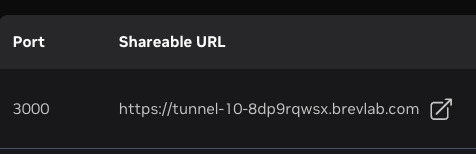

### From localhost

Open your browser and navigate to: `http://localhost:3000`

### Verify NIMs

At the top right corner of the website, there are four dots. Each dot represents a NIM. When all NIMs are running healthy, you should see them in green:

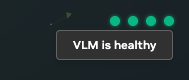

## Stopping Services and Cleaning Up

To shut down the microservices, run the following command

In [ ]:
!docker compose down > /dev/null 2>&1

## Troubleshooting

### Common Issues and Solutions

#### 1. HuggingFace Token Error

**Issue:** When starting the FLUX model container, you may encounter the following error:
```
Cannot download model manifest: Try acquire: no permits available
```

**Solution:** This typically occurs with older HuggingFace tokens. To resolve:

1. Generate a new HuggingFace API token at https://huggingface.co/settings/tokens
2. Open a console. Update the `HF_TOKEN` environment variable with the new token:
   ```bash
   export HF_TOKEN=new_token
   ```
3. Restart the failed containers:
   ```bash
   docker compose up -d --force-recreate nim-flux
   ```

#### 2. Model Download Times

**Issue:** The initial deployment takes longer than expected.

**Explanation:** When running the blueprint for the first time, all models need to be downloaded from their respective sources. Depending on your internet connection speed, this process can take 20-30 minutes or longer. The models include:
- NVIDIA Nemotron VLM
- NVIDIA Nemotron LLM  
- FLUX image generation model
- TRELLIS 3D asset generation model

**Solution:** Be patient and allow sufficient time for the initial download. You can monitor the download progress by checking the container logs:
```bash
docker compose logs -f
```

Subsequent starts will be much faster as the models are cached locally.


## LICENSE

GOVERNING TERMS: The Blueprint scripts are governed by Apache License, Version 2.0, and enables use of separate open source and proprietary software governed by their respective licenses: [NVIDIA-Nemotron-Nano-12B-v2-VL](https://catalog.ngc.nvidia.com/orgs/nim/teams/nvidia/containers/nemotron-nano-12b-v2-vl?version=1), [Llama-3.3-nemotron-super-49b-v1.5](https://catalog.ngc.nvidia.com/orgs/nim/teams/nvidia/containers/llama-3.3-nemotron-super-49b-v1.5?version=1), [FLUX.1-Kontext-Dev](https://huggingface.co/black-forest-labs/FLUX.1-Kontext-dev/blob/main/LICENSE.md), and [Microsoft TRELLIS](https://catalog.ngc.nvidia.com/orgs/nim/teams/microsoft/containers/trellis?version=1).

ADDITIONAL INFORMATION: 
FLUX.1-Kontext-Dev license: [https://huggingface.co/black-forest-labs/FLUX.1-Kontext-dev/blob/main/LICENSE.md](https://huggingface.co/black-forest-labs/FLUX.1-Kontext-dev/blob/main/LICENSE.md).

Third-Party Community Consideration:
The FLUX Kontext model is not owned or developed by NVIDIA. This model has been developed and built to a third-party’s requirements for this application and use case; see link to: black-forest-labs/FLUX.1-Kontext-dev Model Card - [https://huggingface.co/black-forest-labs/FLUX.1-Kontext-dev](https://huggingface.co/black-forest-labs/FLUX.1-Kontext-dev).

This project will download and install additional third-party open source software projects. Review the license terms of these open source projects before use. 